### Exploratory Data Analysis & Feature Engineering

Objective:
    1. To get an insight into input dataframe.
    2. To get an understanding of basic statistics.
    3. Identify features of importance through VIF, PCA and / or Decision Trees

Assumptions:
    1. Only *.csv files are currently being read.
    2. Target columns are placed after the features in the *.csv
    3. Median imputing is performed where needed. Change it appropriately as needed.
    
EDA on Rawdataset:
    1. No missing data.
    2. Features are a mix of categorical and continuous data.
    3. Encoding is not needed as the dataset is pre-encoded.
    4. Dataset is having heavy outliers as expected.
    5. High correlation among payments and bill amount.
    6. 8+ features are needed to explain the feature variance >=95%
    7. Top features from Decision Tree Classification ['PAY_0', 'PAY_2', 'PAY_AMT3', 'PAY_5', 'BILL_AMT1', 'LIMIT_BAL']

Modifications to Raw dataset:
    1. Limit Balance > 600 K USD are not considered
        Impact: 95/30000 ~=0.3 %
    2. People who have not used the credit nor paid the bill is also dropped:
        Impact: 795/30000 = 2.6%
    3. Handling Correlation:
        a. New Variable 1 = Delta_Bill-paid = Sum of Billed - Sum of Paid.
        b. New Variable 2 = Average Bill Amount
        c. New Variable 3 = Average Bill Amount/Limit_Balance

In [36]:
# Import relevant libraries

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.options.display.width=None

import ppscore as pps

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from pca import pca
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA as SKLPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [37]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [38]:
# Dataset I/O definitions

PATH = r"C:\DSML_Case_Studies_2021.04.24\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies_2021.04.24\03_Output"


In [39]:
# Pick the dataset to be analyzed & specify a prefix for output files and figures

for r, d, f in os.walk(PATH):
    for file in f:
        if file.endswith(".csv"):
            continue
    print(f)
nfiles = len(f)

userinp = int(input("Enter input file index:"))
while userinp > (nfiles-1):
    print(f)
    userinp = int(input("Enter input file index:"))
    continue

files = f[userinp]

FNAME = f"{PATH}\{files}"
PREFIX = input("Prefix for Output Files & Figures: ")
PREFIX = f"\{PREFIX}"

# Specify number of features and targets in the dataset

n_features = int(input("Enter the Number of Features in Dataset: "))
n_target = int(input("Enter the Number of Targets in Dataset: "))

['Dataset_CC_Rawdata_23x1.csv', 'Dataset_Creditcard_Mod_17x0.csv', 'Dataset_Indian_Liver_Patient_10x1.csv', 'Dataset_Insurance_6x1.csv', 'Dataset_Lower_Back_Pain_12x1.csv', 'Dataset_Petrol_Consumption_4x1.csv']
Enter input file index:0
Prefix for Output Files & Figures: CC_Rawdata_
Enter the Number of Features in Dataset: 23
Enter the Number of Targets in Dataset: 1


In [40]:
# Dataset Definition

df = pd.read_csv(f"{FNAME}")
df = df.round(decimals=4)
maxcol = len(df.columns)

DF_INFO = df.dtypes.to_frame('Data Type').reset_index()

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

pd.set_option('display.max_columns', len(collst))

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]


In [41]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [42]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,Yes
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,Yes
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,No
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,No
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,No


In [43]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue


In [44]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [45]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [46]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [47]:
print(df.isnull().sum(), end='\n\n')

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64



In [48]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)


In [49]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [50]:
print(df.isnull().sum(), end='\n\n')

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64



In [51]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

List of Targets: ['default.payment.next.month']

List of Categorical Variables: ['default.payment.next.month']

List of Categorical Targets ['default.payment.next.month']



In [52]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [53]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github"))

|                            |   count |       mean |        std |     min |      25% |      50% |       75% |              max |
|----------------------------|---------|------------|------------|---------|----------|----------|-----------|------------------|
| LIMIT_BAL                  |   30000 | 167484     | 129748     |   10000 | 50000    | 140000   | 240000    |      1e+06       |
| SEX                        |   30000 |      1.604 |      0.489 |       1 |     1    |      2   |      2    |      2           |
| EDUCATION                  |   30000 |      1.853 |      0.79  |       0 |     1    |      2   |      2    |      6           |
| MARRIAGE                   |   30000 |      1.552 |      0.522 |       0 |     1    |      2   |      2    |      3           |
| AGE                        |   30000 |     35.486 |      9.218 |      21 |    28    |     34   |     41    |     79           |
| PAY_0                      |   30000 |     -0.017 |      1.124 |      -2 |    -1    |   

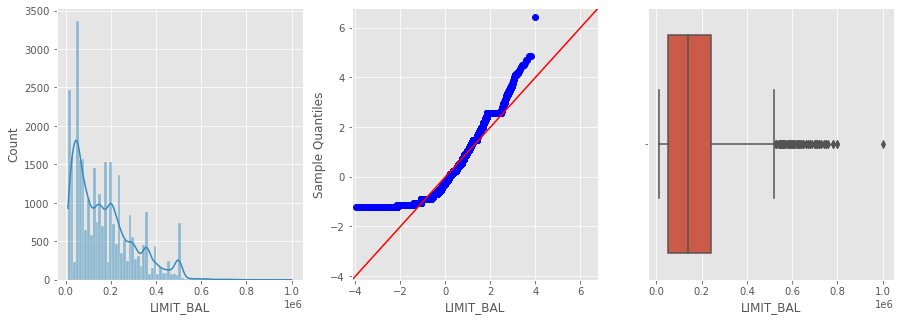

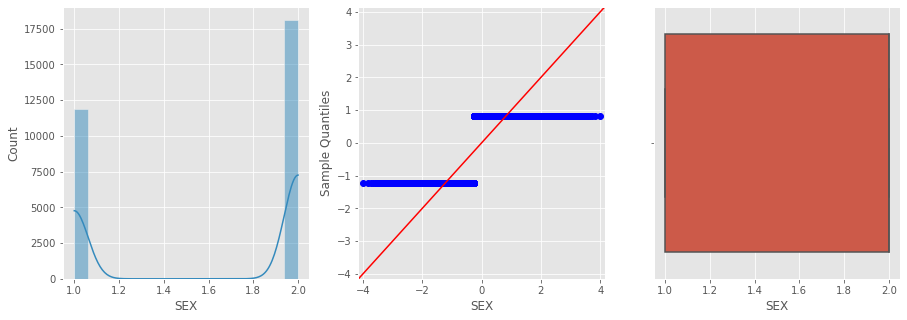

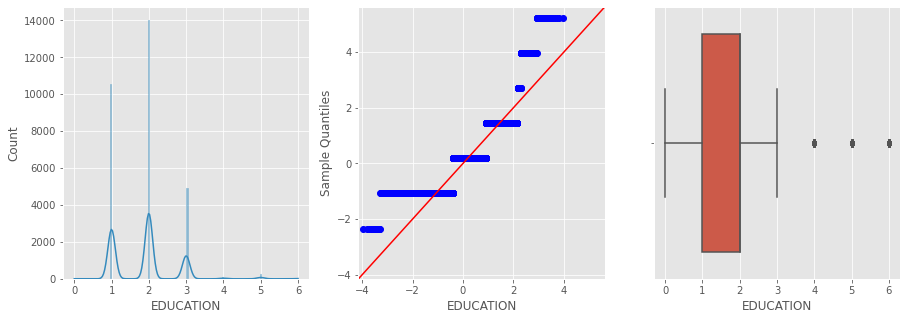

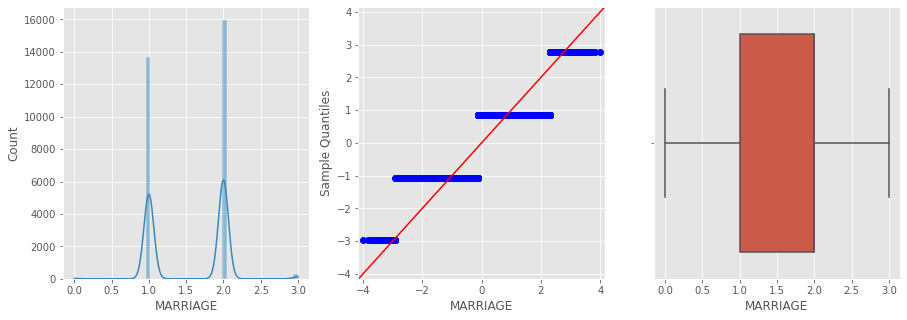

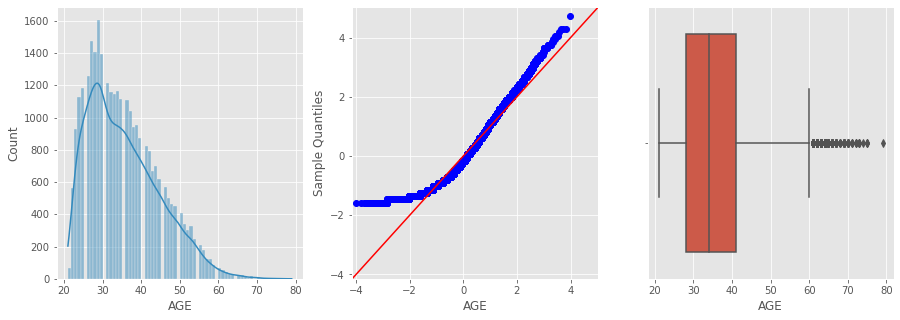

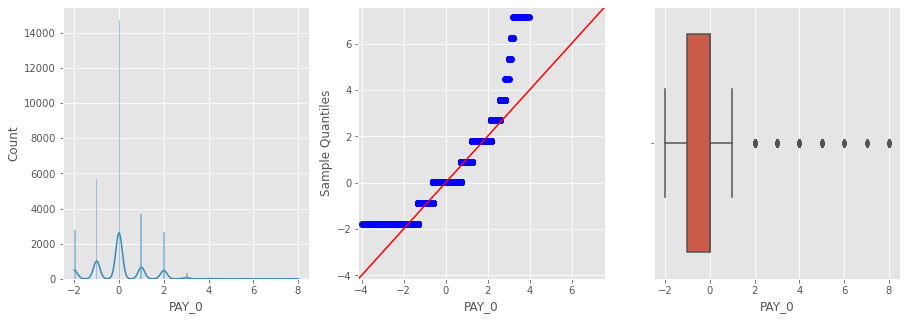

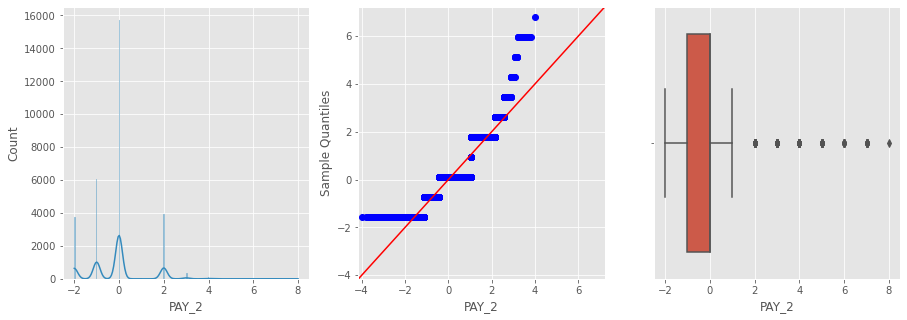

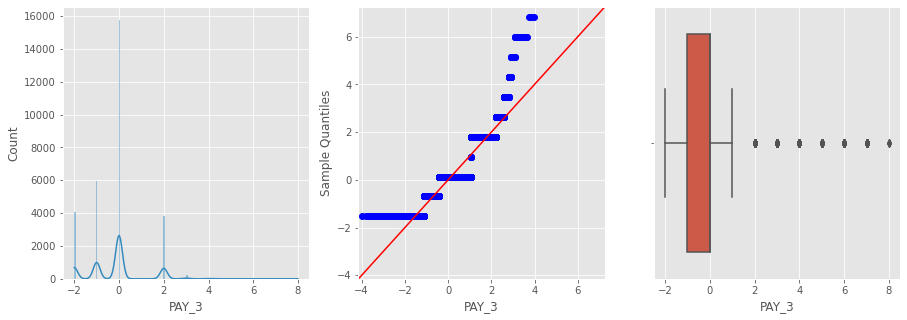

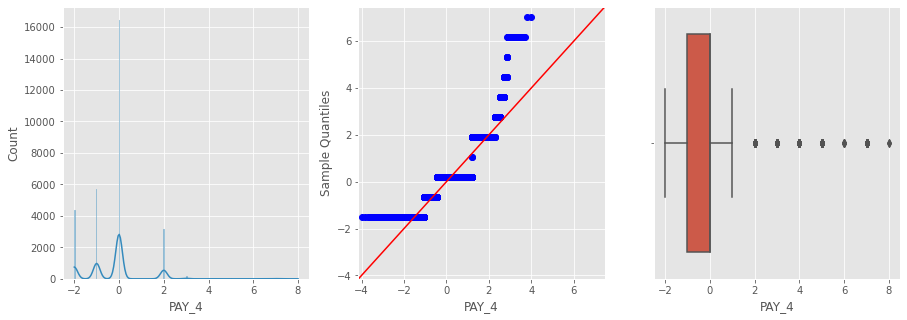

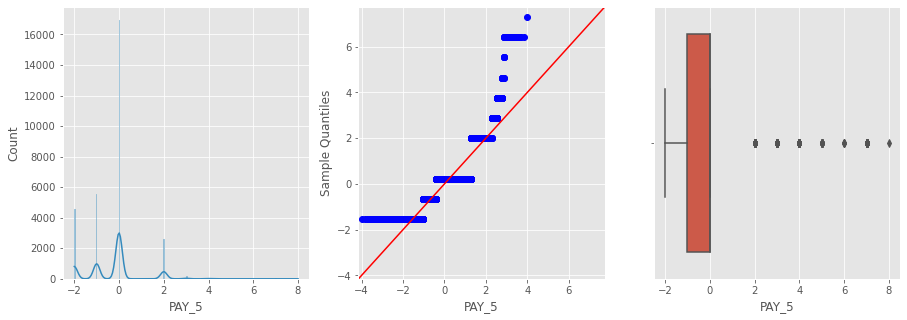

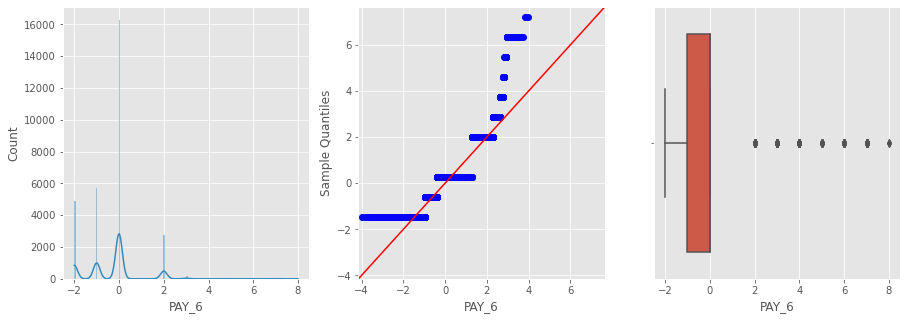

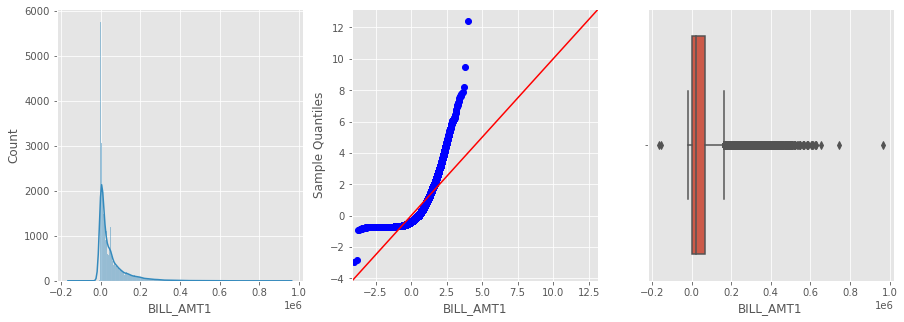

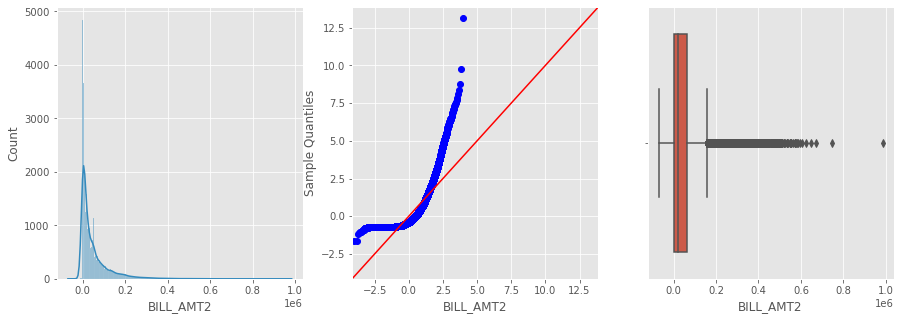

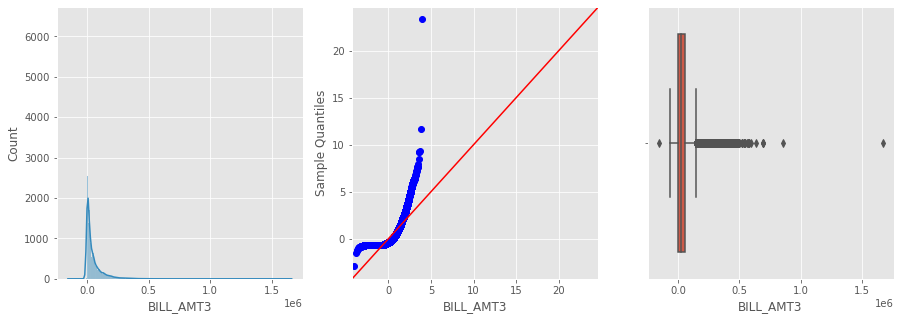

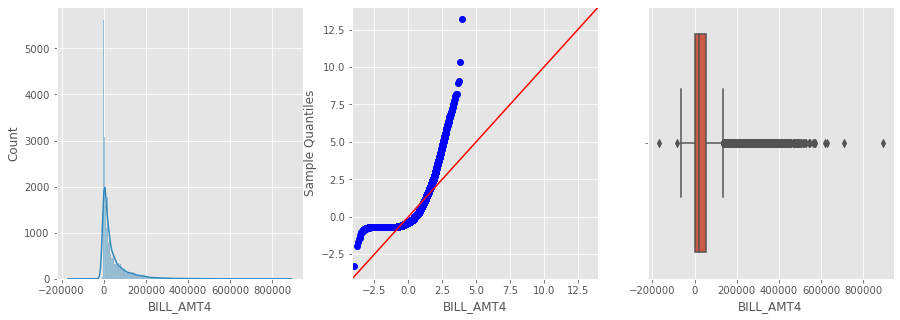

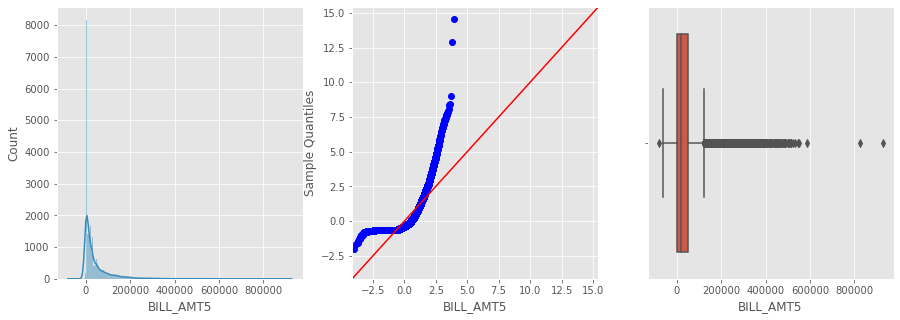

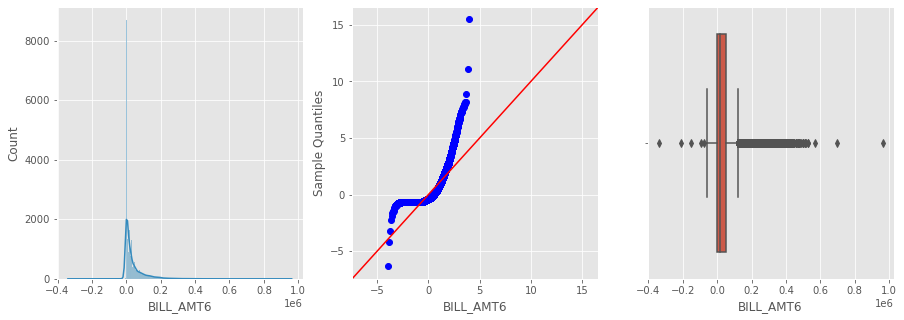

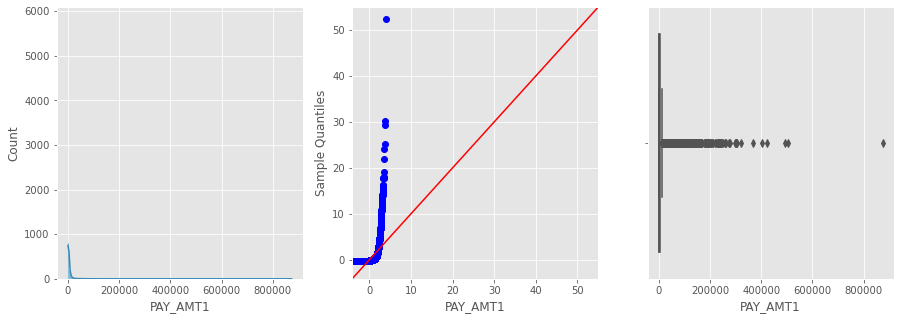

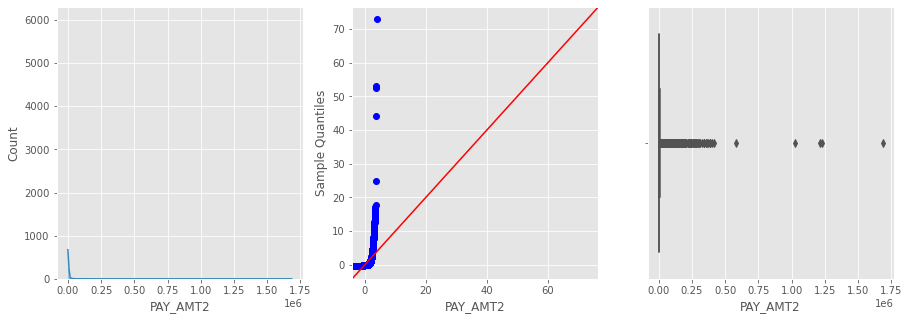

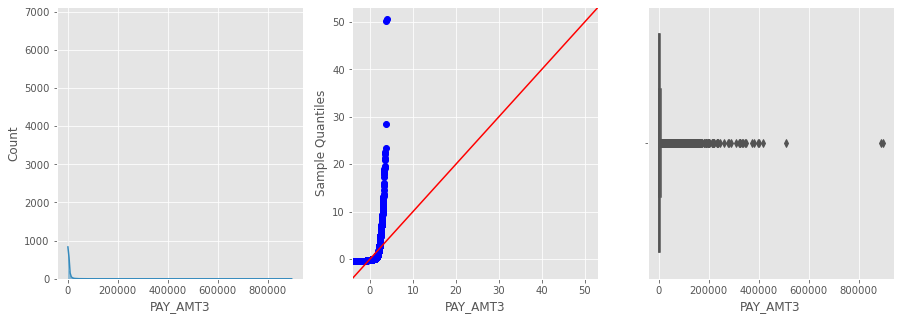

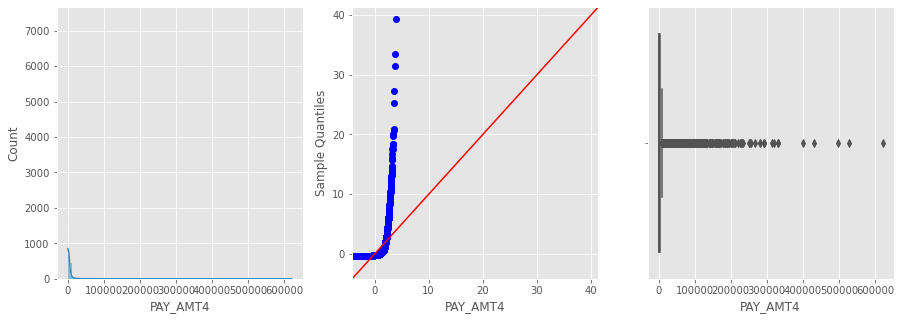

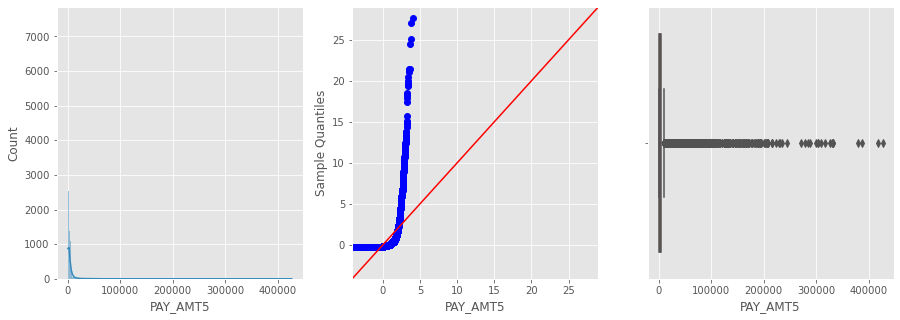

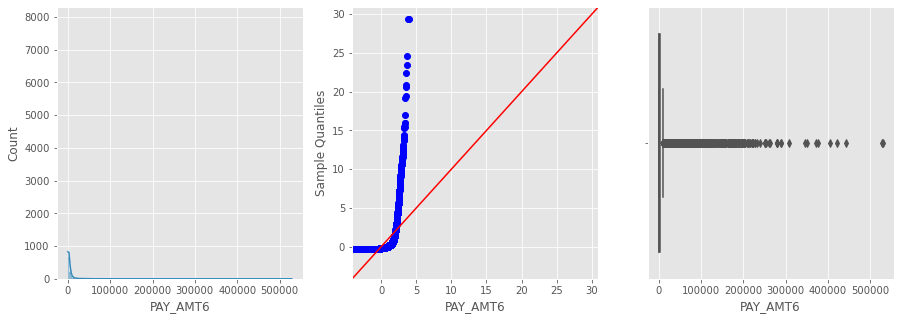

In [54]:
# Check for Normality - Visual Check - Plots not being saved.

for x in featlst:
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
    sns.histplot(data=df,x=x,kde=True,ax=ax[0])
    sm.qqplot(df[x],ax=ax[1],line='45',fit=True)
    ax[1].set_xlabel(x)
    sns.boxplot(data=df,x=x,ax=ax[2])
    plt.show()

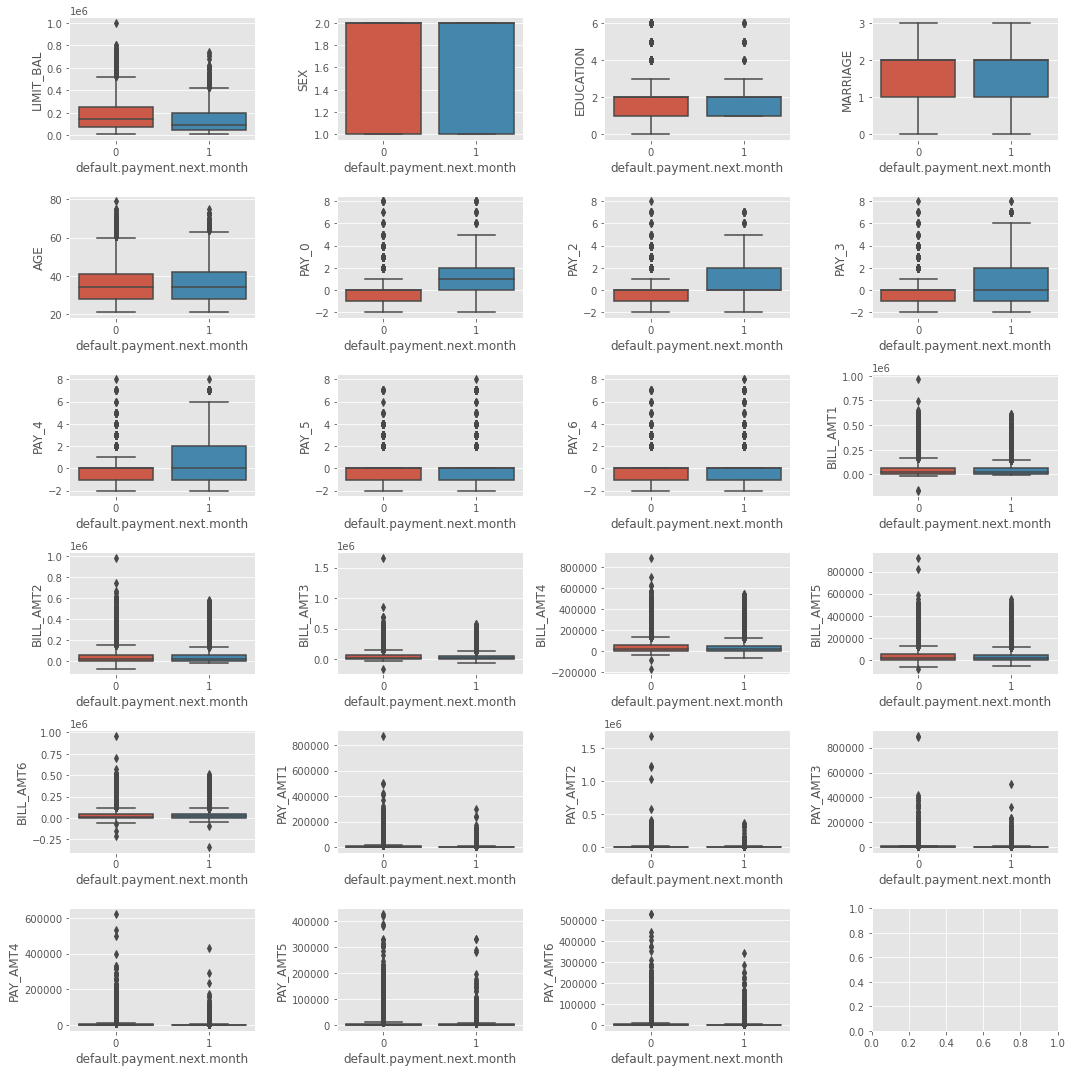

In [55]:
# Box Plot

if len(y_catlst)!= 0:
    NCOLS = 4
    m_rows = int(np.ceil((len(collst)-len(y_catlst))/NCOLS))
    fig, axes = plt.subplots(m_rows, NCOLS, figsize = (15,15))
    axes = axes.flatten()
    for lst in range(0, len(y_catlst), 1):
        temp = 'Fig_0' + str(lst)
        FIG1 = f"{temp}_Boxplot"
        for i in range(0,len(df.columns)-len(y_catlst)):
            sns.boxplot(x=y_catlst[lst], y=df.iloc[:,i], data=df, orient='v', ax=axes[i])
            plt.tight_layout()
            plt.savefig(f"{OUTPATH}{PREFIX}{FIG1}")

if len(y_catlst)== 0:
    FIG1 = r"Fig_01_Boxplot"
    lst = [x for x in collst if x not in y_catlst]
    fig, axes = plt.subplots(1, len(lst), figsize = (45,15))
    axes = axes
    for i, col in enumerate(lst):
        ax = sns.boxplot(y=df[col], ax=axes.flatten()[i])
        axminlt = df[col].min()-0.1*df[col].min()
        axmaxlt = df[col].max()+0.1*df[col].max()
        ax.set_ylim(axminlt, axmaxlt)
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.savefig(f"{OUTPATH}{PREFIX}{FIG1}")

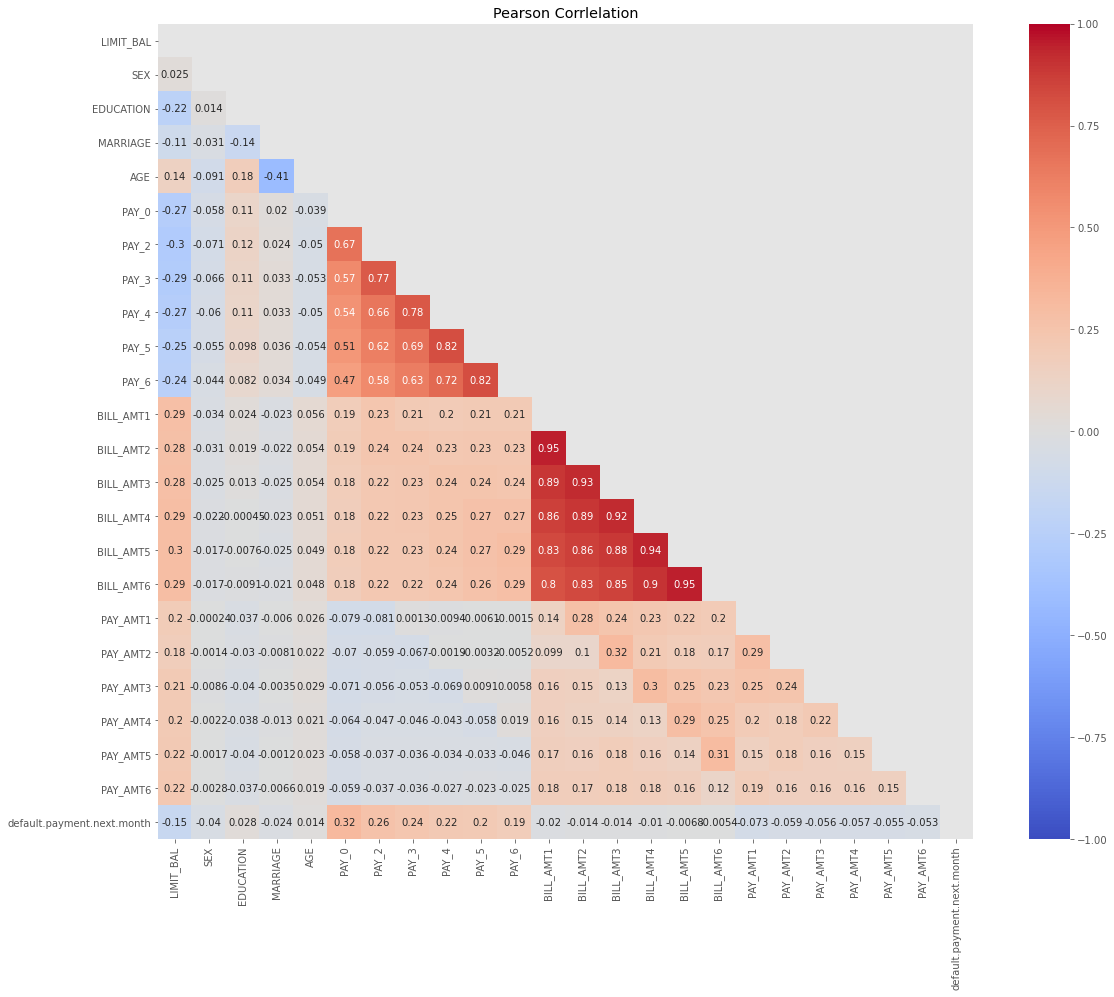

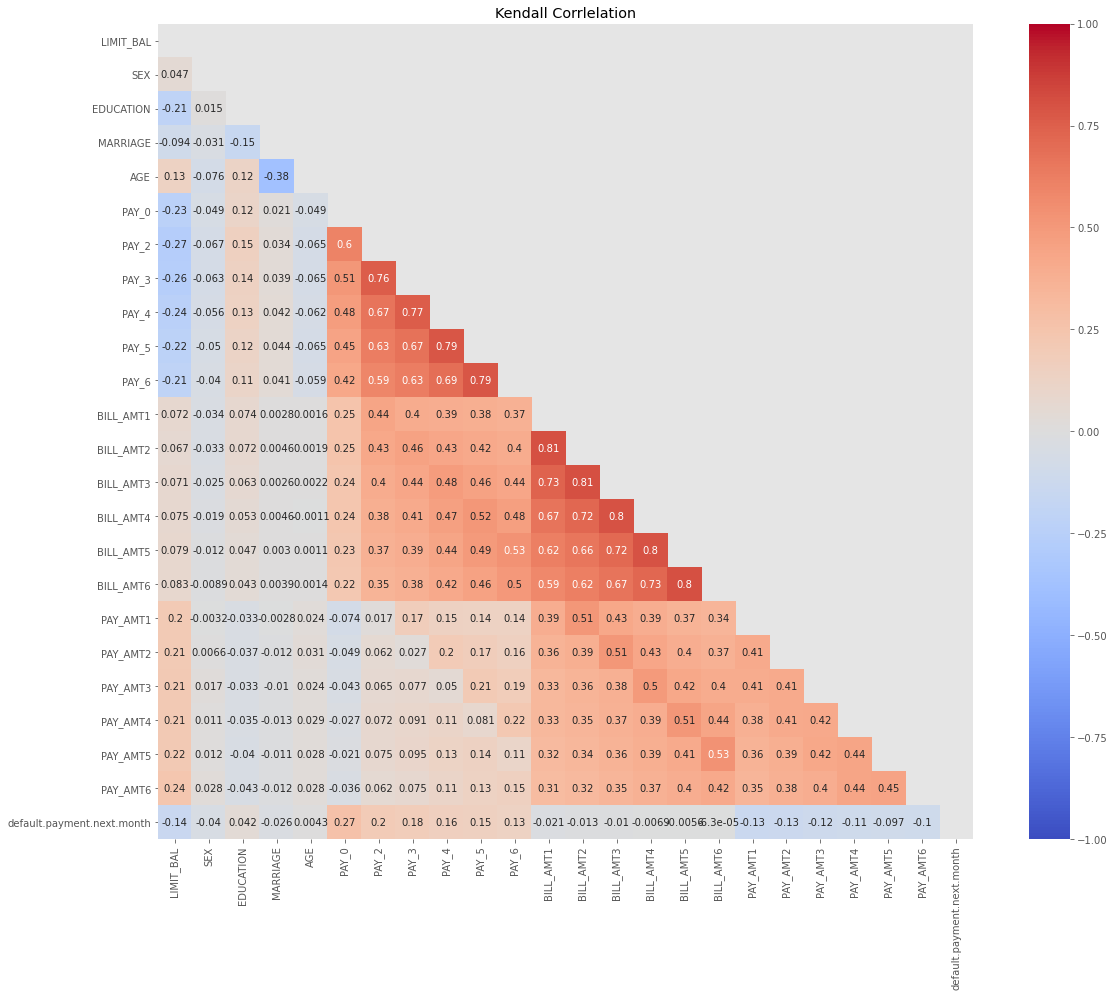

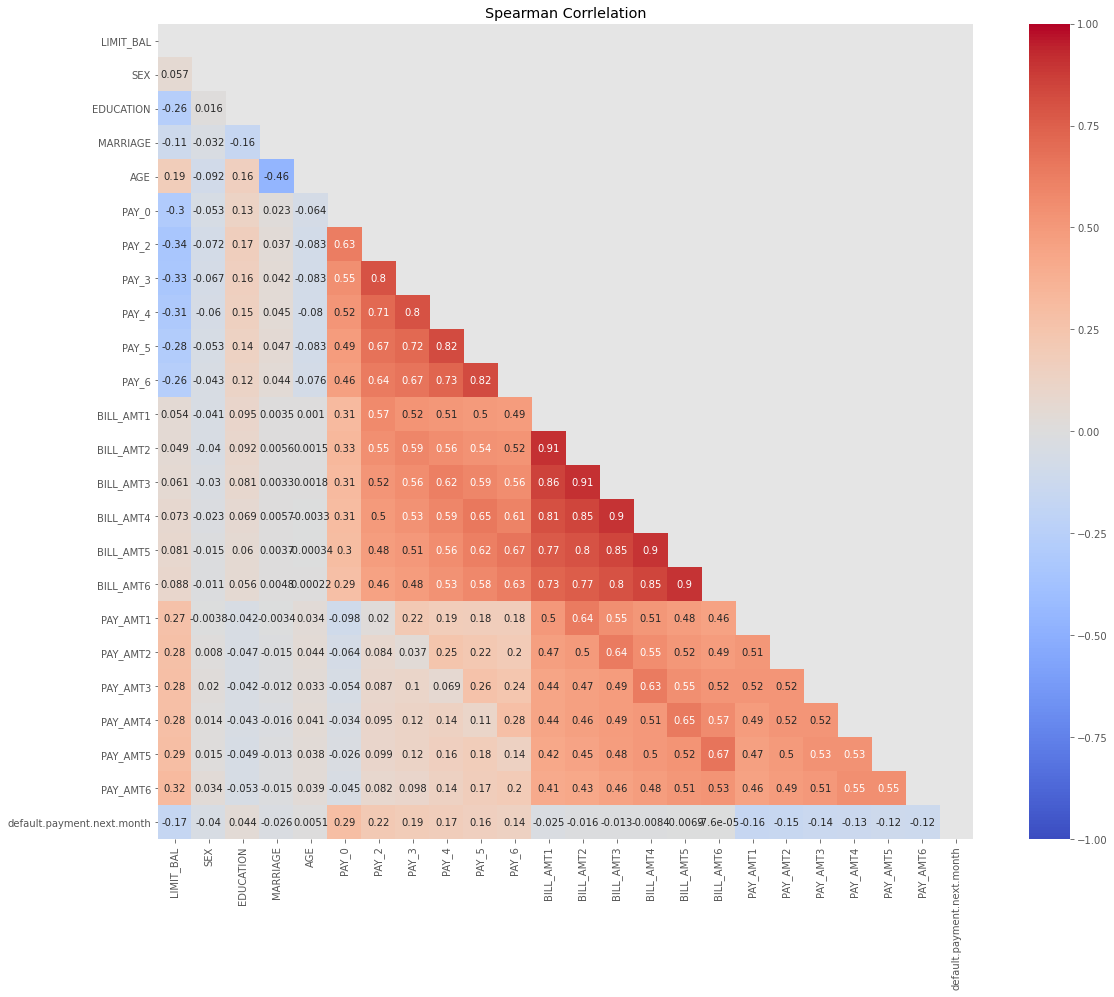

In [56]:
# Linear Correlation Heatmap

cormethod = {0:'pearson', 1:'kendall', 2:'spearman'}
for i in range(0, 3, 1):
    temp = 'linear_cor' + str(i)
    temp = df.corr(method=cormethod[i])
    ftemp = cormethod[i].title()
    FIG2 = r"Fig_02_Corr_"
    mask = np.zeros(temp.shape, dtype=bool)
    mask[np.triu_indices(len(mask))] = True
    plt.subplots(figsize=(20,15))
    plt.title(f"{ftemp} Corrlelation")
    sns.heatmap(temp, annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', square=True, mask=mask)
    plt.savefig(f"{OUTPATH}{PREFIX}{FIG2}{ftemp}")

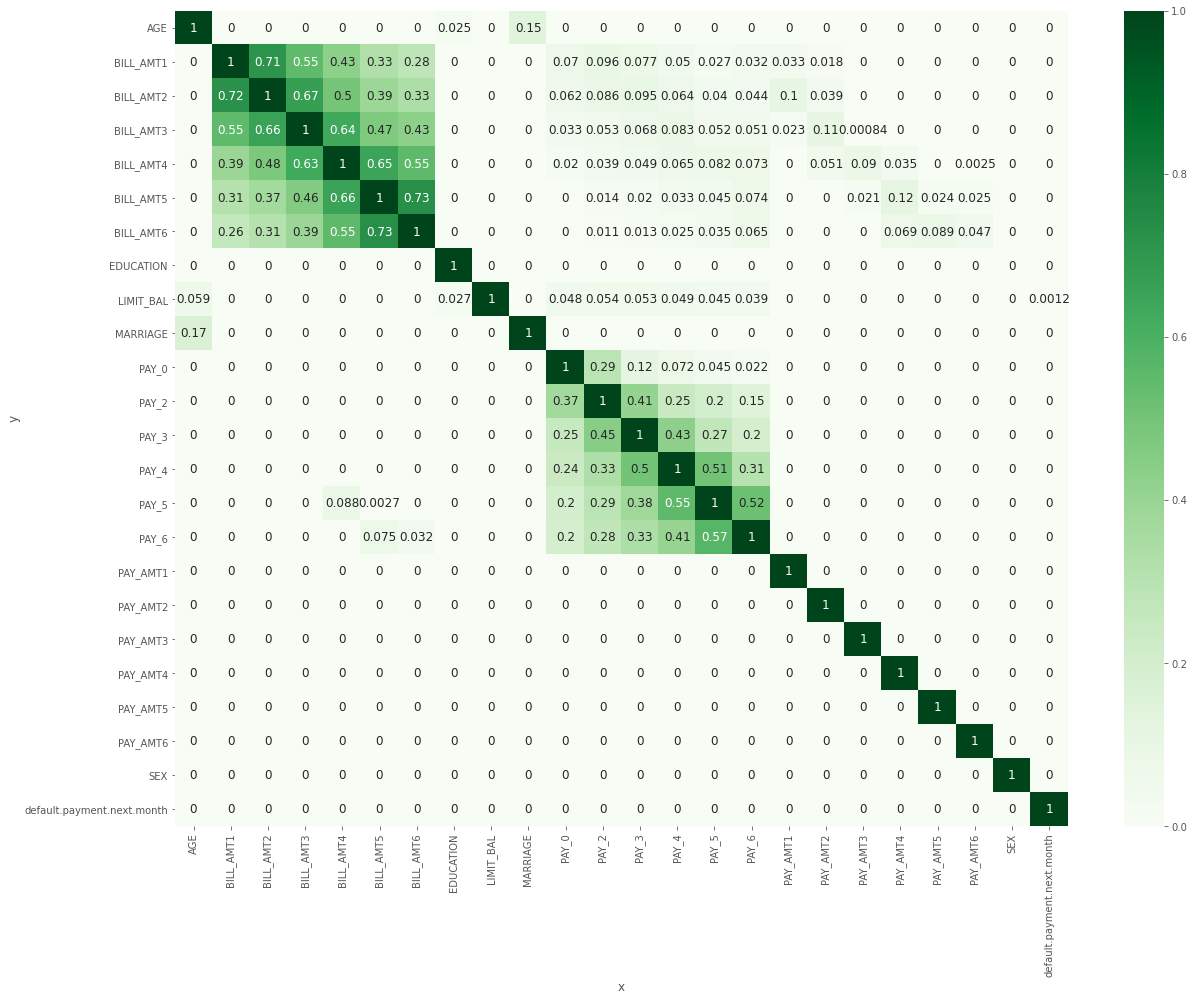

In [57]:
# Non-Linear Correlation Predictive Power Score - Heatmap

FIG3 = r"Fig_03_Predictive_Power_Score"

ppscorr = pps.matrix(df) # Predictive Power Score - PPS
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y',
                                                        values='ppscore')
plt.subplots(figsize=(20,15))
sns.heatmap(matrix_df, cmap="Greens", annot=True, linewidth=0, annot_kws={"size":12}, fmt='.2g')
plt.savefig(f"{OUTPATH}{PREFIX}{FIG3}")

In [58]:
# Feature Reduction -  Variance Inflation Factor [VIF]

vif_data = pd.DataFrame()
vif_data["Feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

No. of Components Explaining 95% Variance: 8
[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [23] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [15] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [23] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [15] that covers the [95.00%] explained variance.
[pc

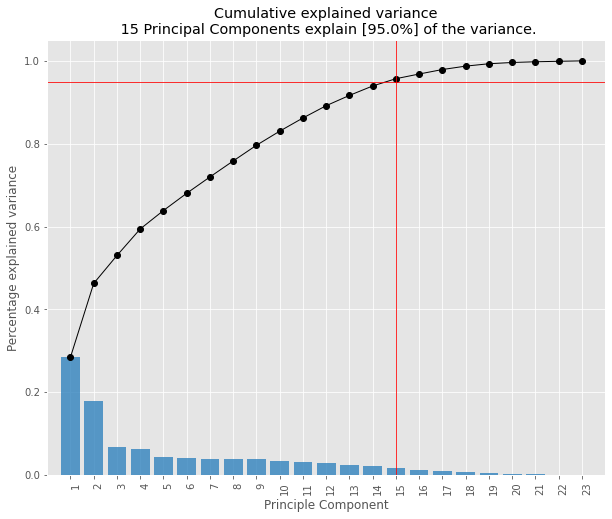

<Figure size 432x288 with 0 Axes>

In [59]:
# Feature Reduction - Principal Component Analysis [PCA]

if n_target == 0:
    X = df.copy()
else:
    X = df.drop(columns=targlst)
    y = df.filter(targlst, axis=1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Principal Component Analyses

sklpca = SKLPCA(n_components=0.95, svd_solver='full')
sklpca.fit(X_scaled)
X_transform = sklpca.transform(X_scaled)

pricom = pd.DataFrame(sklpca.components_.round(3)) # Principal Components
pricomvar = pd.DataFrame(sklpca.explained_variance_ratio_.round(3))

n_pca_comp = sklpca.n_components_
print("No. of Components Explaining 95% Variance:", n_pca_comp)

# Identifying Top Features of  PCA using pca module

model = pca(n_components=0.95, normalize=True, random_state=RND_STATE)
out = model.fit_transform(X)
pcatopfeat = out['topfeat'].round(3)

# Identifying Top Features of  PCA using pca module

model = pca(n_components=0.95, normalize=True, random_state=RND_STATE)
out = model.fit_transform(X)
pcatopfeat = out['topfeat'].round(3)

FIG4 = r"Fig_04_PCA_Model_Plot"
fig, ax = model.plot()
ax.figure.savefig(f"{OUTPATH}{PREFIX}{FIG4}")


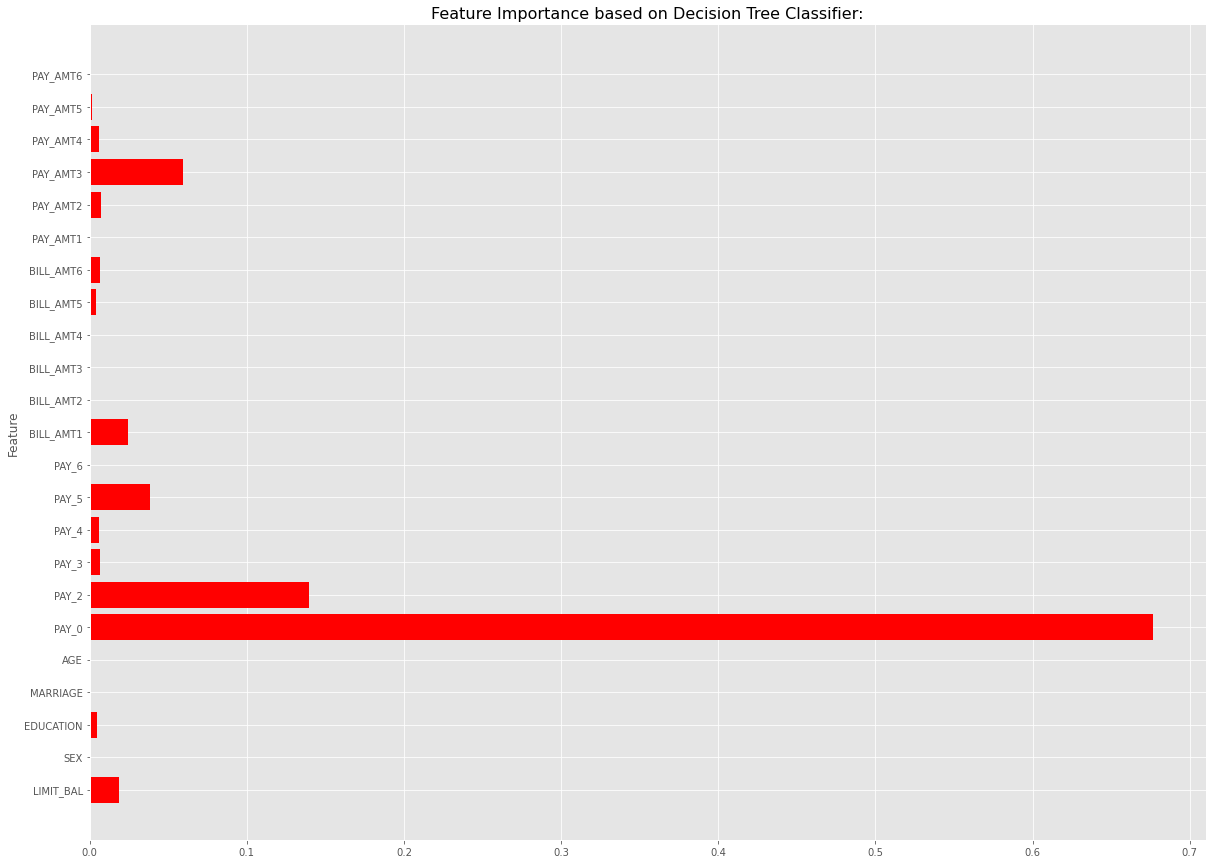

In [60]:
# Feature Importance - Decision Tree Classifier

FIG44 = r"Fig_44_Feature_Importance"

if n_target != 0:
    X = df.drop(columns=targlst)
    y = df.drop(columns=featlst)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE,
                                                        random_state=RND_STATE)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    MLM_DTR = DecisionTreeClassifier(max_depth=5, random_state=RND_STATE)
    MLM_DTR.fit(X_train, y_train)
    feat_imp = MLM_DTR.feature_importances_.round(3)
    colhead = X.columns.tolist()
    featimp = pd.DataFrame(np.column_stack([colhead, feat_imp]), columns=['Features',
                                                                          'Coefficients'])
    featimp = featimp.sort_values('Coefficients', ascending=False)
else:
    featimptemp = {'Features':[np.nan], 'Coefficients':[np.nan],
                   'Remarks':['Unsupervised Learning']}
    featimp = pd.DataFrame(featimptemp, columns=['Features',
                                                 'Coefficients', 'Remarks'])

plt.figure(figsize=(20, 15))
plt.yticks(range(0, len(featlst)), featlst)
plt.barh(range(0, len(featlst)), MLM_DTR.feature_importances_, color='red', align='center')
plt.ylabel('Feature', fontsize=12)
plt.title("Feature Importance based on Decision Tree Classifier:", fontsize=16)
plt.savefig(f"{OUTPATH}{PREFIX}{FIG44}")

Top Features: ['PAY_0', 'PAY_2', 'PAY_AMT3', 'PAY_5', 'BILL_AMT1', 'LIMIT_BAL']


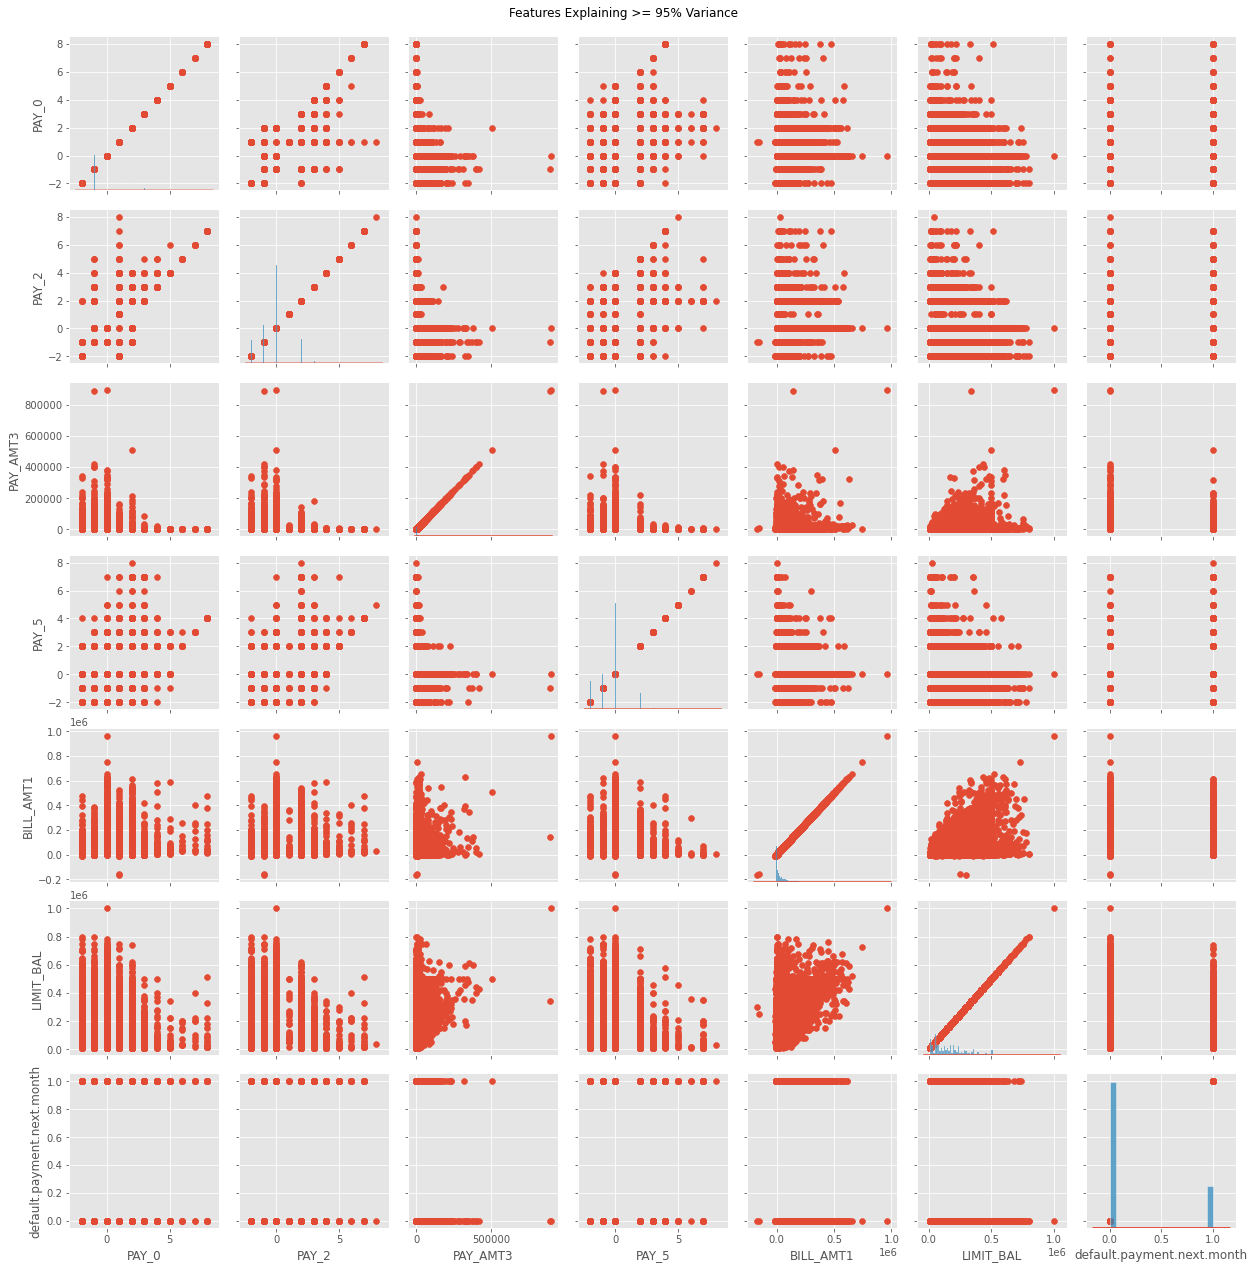

In [61]:
# Scatter Plot of Top Features of Importance from DTR

FIG5 = r"Fig_05_Scatter_Plot"

temp = featimp["Coefficients"].to_numpy()

cumsum = 0
for i in range(0, len(temp), 1):
    cumsum = cumsum + float(temp[i])
    if cumsum >= 0.95:
        break
    else:
        continue

n_crit_feat = i

DTR_featlst = featimp['Features'].to_list()
topfeat = []
for i in range(0, n_crit_feat+1, 1):
    topfeat.append(DTR_featlst[i])
print("Top Features:", topfeat, end='\n')

topfeat.extend(targlst) # Adding target variables to topfeatures

df_scatter = df.filter(topfeat, axis=1)
grid1 = sns.pairplot(df_scatter, hue=None)
grid1.map(plt.scatter)
grid1.map_diag(sns.kdeplot)
grid1.add_legend()
grid1.fig.suptitle("Features Explaining >= 95% Variance", y=1.01)
grid1.savefig(f"{OUTPATH}{PREFIX}{FIG5}")

In [62]:
# EDA Report Out

# Output to Excel

SUMMARY = r"00_Results_Summary.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{SUMMARY}", engine='xlsxwriter', options={'strings_to_numbers': True})
DF_INFO.to_excel(writer, sheet_name='Info')
desc_stat.to_excel(writer, sheet_name='Stats')
vif_data.to_excel(writer, sheet_name='VIF')
pricomvar.to_excel(writer, sheet_name='PCA_VAR')
pricom.to_excel(writer, sheet_name='PCA_Components')
pcatopfeat.to_excel(writer, sheet_name='PCA_Top_Features')
featimp.to_excel(writer, sheet_name='DTR-Features')
writer.save()